In [ ]:
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import json
import sys
import statsmodels.api as sm
import os
import kad.visualization.visualization as visualization
import kad.kad_utils.kad_utils as kad_utils
import kad.models_evaluation.models_evaluator as models_evaluator

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

import kad.ts_analyzer.ts_analyzer as ts_analyzer
from kad.model import i_model
from kad.model import sarima_model
from sklearn.model_selection import train_test_split

kad_utils.customize_matplotlib()

# Reading data

In [13]:
data_dir = "data/archive/"
file_dir = "artificialWithAnomaly"
file_name = "artificialWithAnomaly/art_daily_flatmiddle.csv"
# file_dir = "artificialWithAnomaly"
# file_name = "artificialWithAnomaly/art_daily_jumpsup.csv"

file_path = os.path.join(data_dir, file_dir, file_name)

original_df = pd.read_csv(
    file_path, parse_dates=True, index_col="timestamp"
)

original_df = original_df.resample("h").agg(np.mean)

with open("data/archive/combined_windows.json") as f:
    true_anomalies = json.load(f)

# Data preprocessing

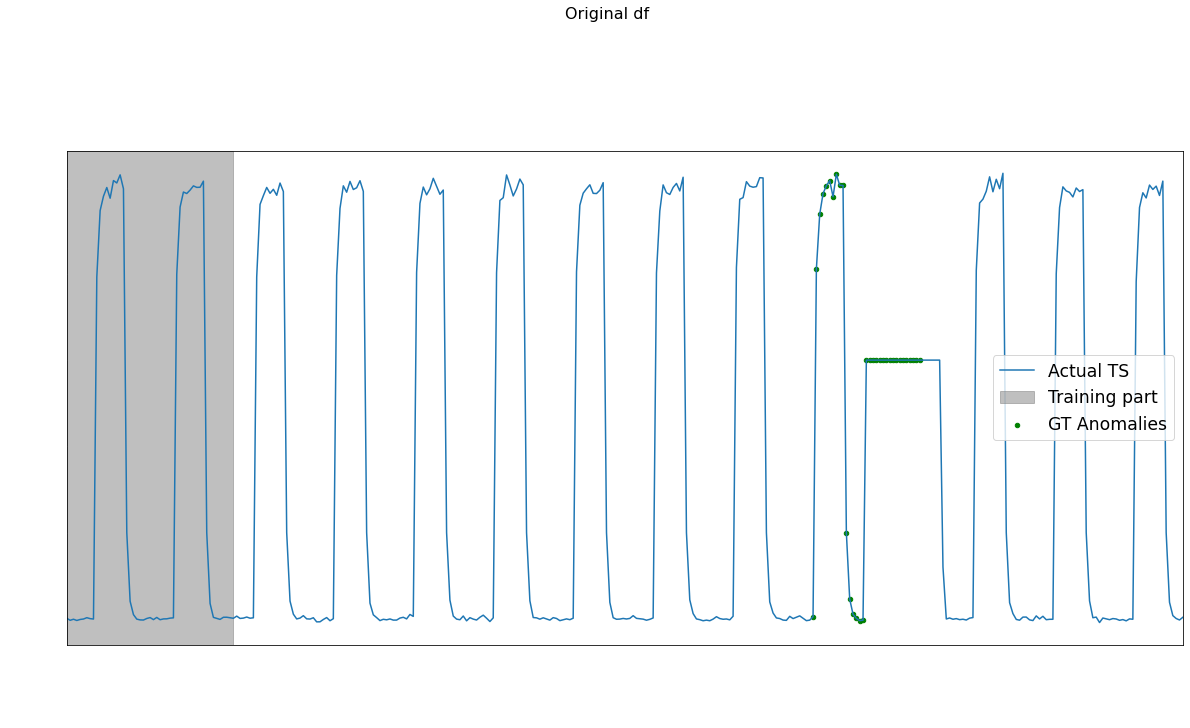

In [14]:
X_LABEL = "timestamp"

true_anomalies_ranges = true_anomalies[file_name]

ground_true_anomalies_df = pd.DataFrame()
for anom_range in true_anomalies_ranges:
    ground_true_anomalies_df = ground_true_anomalies_df.append(original_df.loc[anom_range[0]:anom_range[1]])

preprocessed_df = original_df.copy()
preprocessed_df["gt_is_anomaly"] = [idx in ground_true_anomalies_df.index for idx in original_df.index.tolist()]

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Original df")

In [15]:
ground_true_anomalies_df

,value
timestamp,
2014-04-10 08:00:00,-19.513645
2014-04-10 09:00:00,61.131030
2014-04-10 10:00:00,73.805576
2014-04-10 11:00:00,78.602057
2014-04-10 12:00:00,80.454219
2014-04-10 13:00:00,81.608450
2014-04-10 14:00:00,77.887929
2014-04-10 15:00:00,83.098889
2014-04-10 16:00:00,80.530097


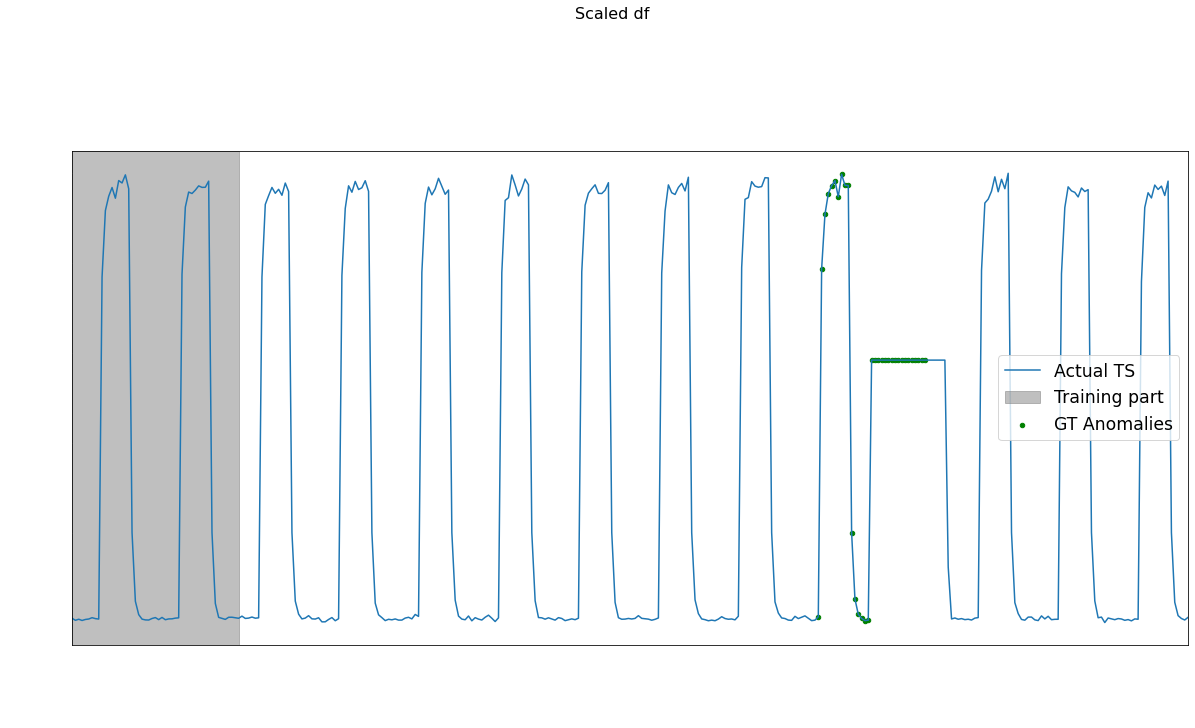

In [16]:
scaler = MinMaxScaler(feature_range=(-1, 0))
preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Scaled df")


In [17]:
values_df = preprocessed_df[["value"]]
tsa = ts_analyzer.TsAnalyzer(values_df)
print("Is TS stationary: ", tsa.is_stationary())


Statistics analysis

Statistic Test :  -10.211070086929512
p-value :  5.6365037513635285e-18
# n_lags :  12
No of observation:  323
 critical value 1% : -3.4507587628808922
 critical value 5% : -2.870530068560499
 critical value 10% : -2.5715597727381647
Is TS stationary:  True


/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Text(0.5, 0.98, 'ACF & PACF')

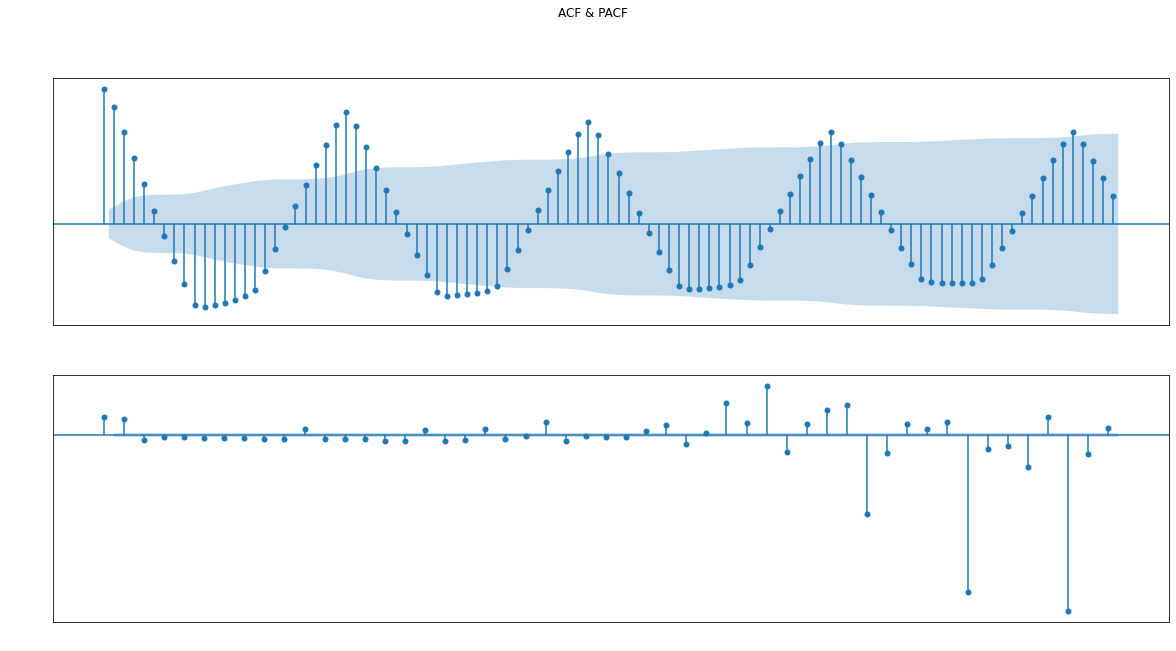

In [18]:
f = plt.figure(figsize=(20, 10))
ax = f.add_subplot(2, 1, 1)
_ = sm.graphics.tsa.plot_acf(values_df, lags=100, ax=ax)
ax2 = f.add_subplot(2, 1, 2)
_ = sm.graphics.tsa.plot_pacf(values_df, lags=50, ax=ax2)
f.suptitle("ACF & PACF")

In [19]:
dominant_freq = tsa.calculate_dominant_frequency()

# SARIMA

                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                   35
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood                   9.686
Date:                    Sun, 16 May 2021   AIC                            -13.372
Time:                            13:14:35   BIC                             -8.706
Sample:                                 0   HQIC                           -11.761
                                     - 35                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9998      0.000   7047.380      0.000       1.000       1.000
ma.S.L24       9.9127      2.532      3.915      0.000       4.950      14.875
sigma2        1.3e-0

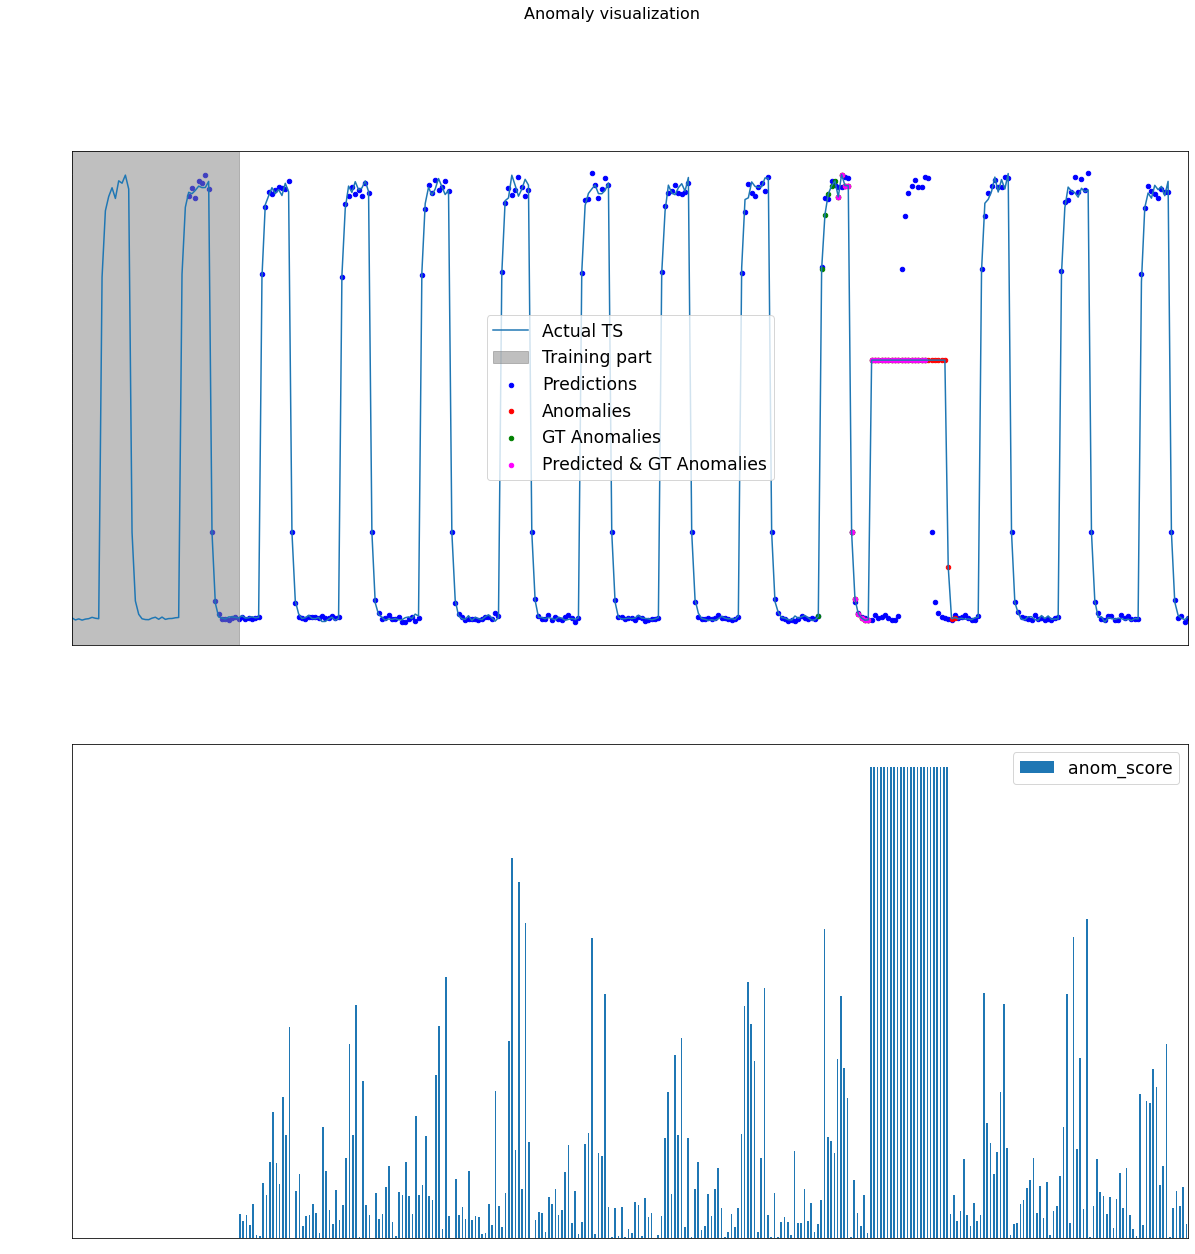

In [20]:
sarima_model = importlib.reload(sarima_model)
kad_utils = importlib.reload(kad_utils)

model: i_model.IModel = sarima_model.SarimaModel(order=(0, 0, 0), seasonal_order=(1, 0, 1, dominant_freq))

# warnings.filterwarnings("ignore")
train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
model.train(train_df)

results_df = pd.DataFrame()
SAMPLES_TO_PREDICT = 18
for i in range(0, len(test_df), SAMPLES_TO_PREDICT):
    results_df = model.test(test_df.iloc[i:i + SAMPLES_TO_PREDICT])

visualization = importlib.reload(visualization)
evaluation_df = results_df.copy()
evaluation_df["gt_is_anomaly"] = preprocessed_df["gt_is_anomaly"]
visualization.visualize(evaluation_df, metric_name="value")

<ipython-input-21-1b4dcc9fdba8>:3: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  evaluation_df = evaluation_df.loc[test_df.index & evaluation_df.index]


Accuracy:  0.95
Avg precision:  0.5
Recall:  0.82


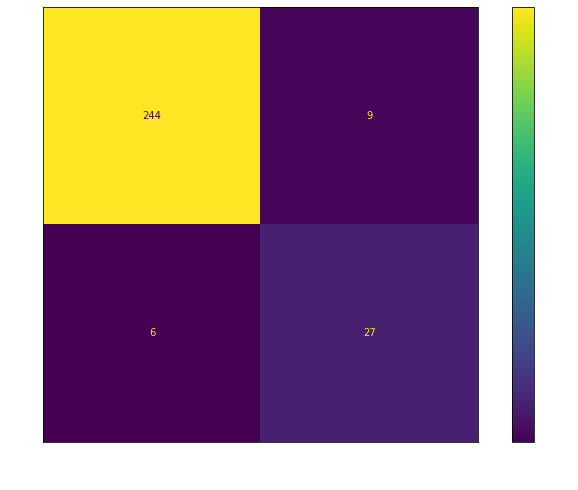

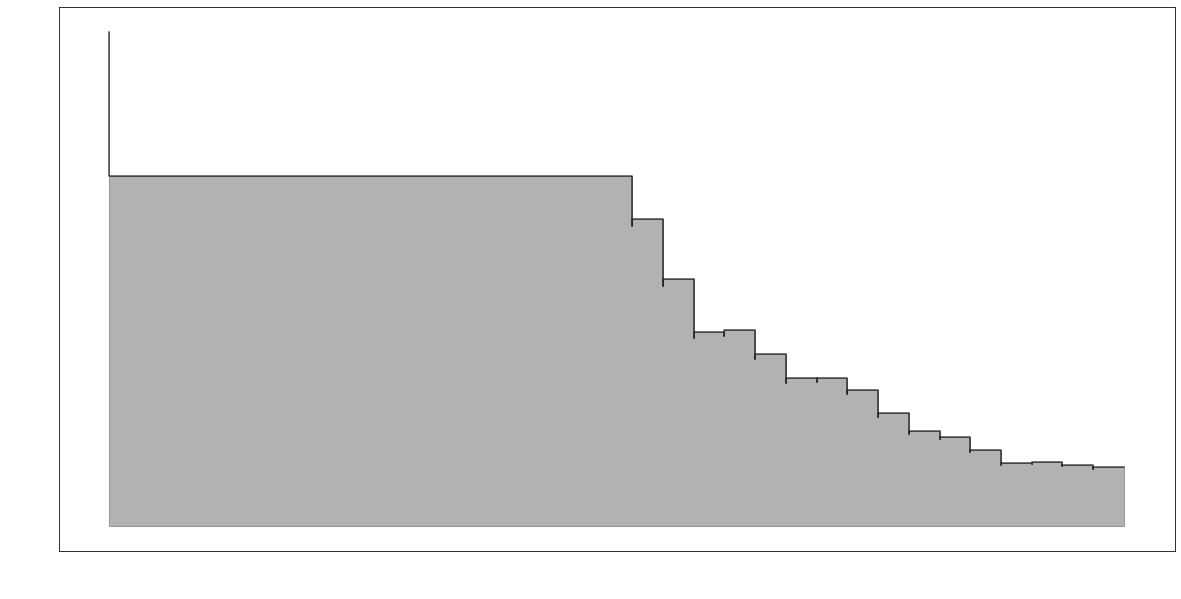

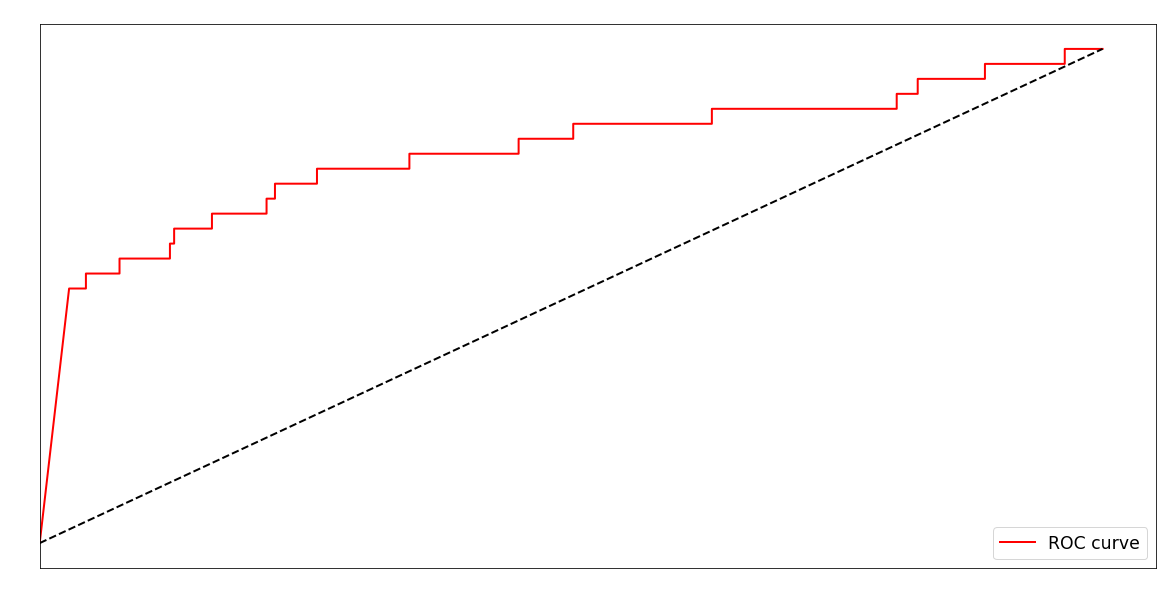

In [21]:
models_evaluator = importlib.reload(models_evaluator)

evaluation_df = evaluation_df.loc[test_df.index & evaluation_df.index]
evaluator = models_evaluator.ModelsEvaluator(df=evaluation_df)

print("Accuracy: ", evaluator.get_accuracy())
print("Avg precision: ", evaluator.get_average_precision())
print("Recall: ", evaluator.get_recall_score())

evaluator.plot_confusion_matrix()

evaluator.plot_precision_recall_curve()
evaluator.plot_roc()

# SEARCHING FOR THE BEST PARAMS

In [22]:
# import itertools
#
# ### Define Parameter Ranges to Test ###
#
# # Note: higher numbers will result in code taking much longer to run
# # Here we have it set to test p,d,q each = 0, 1 & 2
#
# # Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
# p = d = q = range(0, 3)
#
# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))
#
# # Generate all different combinations of seasonal p, q and q triplets
# # Note: here we have 12 in the 's' position as we have monthly data
# # You'll want to change this according to your time series' frequency
# pdqs = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
#
#
# ### Run Grid Search ###
#
# # Note: this code will take a while to run
#
# # Define function
# def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M'):
#     '''
#     Input:
#         ts : your time series data
#         pdq : ARIMA combinations from above
#         pdqs : seasonal ARIMA combinations from above
#         maxiter : number of iterations, increase if your model isn't converging
#         frequency : default='M' for month. Change to suit your time series frequency
#             e.g. 'D' for day, 'H' for hour, 'Y' for year.
#
#     Return:
#         Prints out top 5 parameter combinations
#         Returns dataframe of parameter combinations ranked by BIC
#     '''
#
#     # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
#     ans = []
#     for comb in pdq:
#         for combs in pdqs:
#             try:
#                 mod = sm.tsa.statespace.SARIMAX(ts,  # this is your time series you will input
#                                                 order=comb,
#                                                 seasonal_order=combs,
#                                                 enforce_stationarity=True,
#                                                 enforce_invertibility=False)
#
#                 output = mod.fit(maxiter=maxiter)
#                 ans.append([comb, combs, output.bic])
#                 print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
#             except Exception as exc:
#                 print(exc)
#                 continue
#
#     # Find the parameters with minimal BIC value
#
#     # Convert into dataframe
#     ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
#
#     # Sort and return top 5 combinations
#     ans_df = ans_df.sort_values(by=['bic'], ascending=True)[0:5]
#
#     return ans_df
#
#
# ### Apply function to your time series data ###
#
# # Remember to change frequency to match your time series data
# sarimax_gridsearch(train_df.values, pdq, pdqs, freq='D')